In [60]:
# load and transform the data
import pandas as pd
df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]

import numpy as np


# binary transformation of categorical attribute needed
df_heart['famhist'] = df_heart['famhist'].map({'Present': 1, 'Absent': 0})

# log transform skewed columns as described in part 1:
columns_to_log_transform = ['tobacco','alcohol']
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

# center the data to have mean = 0 and variance = 1
# manual scalation of the data returns very slightly different values due to float representation:
df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

df_heart_standarized.head()

,sbp,ldl,adiposity,obesity,typea,age,tobacco,alcohol,famhist,chd
row.names,,,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.176594,-0.418017,0.628654,1.576878,1.772852,1,1.372375
2,0.276789,-0.159507,0.411694,0.670646,0.193134,1.381617,-1.193044,-0.563821,0,1.372375
3,-0.991731,-0.608585,0.883374,0.734723,-0.112441,0.217947,-1.120397,-0.259134,1,-0.727086
4,1.545310,0.806252,1.622382,1.411091,-0.214300,1.039361,1.116254,0.858159,1,1.372375
5,-0.211103,-0.598928,0.305020,-0.012842,0.702427,0.423301,1.702714,1.422062,1,1.372375


Data has been standardized and log transformations were applied to the features that were highly skewed, tobacco and alcohol. The binary category famhist have been transformed to 0 and 1.

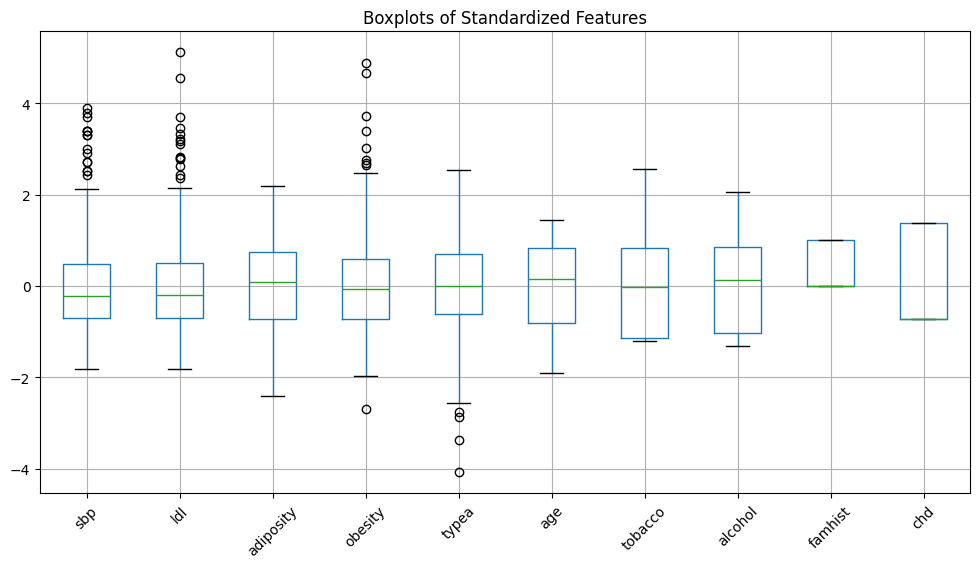

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df_heart_standarized.boxplot(rot=45)
plt.title("Boxplots of Standardized Features")
plt.show()

In [62]:
# use 6 pc's as found in project 1 to describe above 90% of the variance
from sklearn.decomposition import PCA
# drop the column we want to predict
X = df_heart_standarized.drop(columns=["sbp"])
y = df_heart_standarized["sbp"]
pca = PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)
X_pca



array([[ 1.57242499, -2.25063586,  0.01811612,  0.18995855,  0.73393668,
         0.48663369],
       [ 0.90167809,  0.64584292,  0.37552524, -0.83417209, -1.00831696,
         1.20159938],
       [-0.02101074,  1.3045665 , -0.56997211,  0.5527693 , -0.80695313,
         0.37327154],
       ...,
       [-1.3553548 , -2.05753491, -1.70963466,  0.1724469 , -0.45277967,
        -0.30377333],
       [ 1.72964204,  0.71921234,  1.0773194 ,  0.71449613,  2.74299141,
        -1.39253061],
       [-0.56860937, -0.25417161,  1.3363669 , -2.16284688, -0.37533525,
         0.53352444]], shape=(462, 6))

In [63]:
# sbp column has index 0
X = df_heart_standarized.iloc[:, 1:]  # DataFrame
y = df_heart_standarized.iloc[:, 0]
print(X.head)
print(y.head)

<bound method NDFrame.head of                 ldl  adiposity   obesity     typea       age   tobacco  \
row.names                                                                
1          0.477894  -0.295183 -0.176594 -0.418017  0.628654  1.576878   
2         -0.159507   0.411694  0.670646  0.193134  1.381617 -1.193044   
3         -0.608585   0.883374  0.734723 -0.112441  0.217947 -1.120397   
4          0.806252   1.622382  1.411091 -0.214300  1.039361  1.116254   
5         -0.598928   0.305020 -0.012842  0.702427  0.423301  1.702714   
...             ...        ...       ...       ...       ...       ...   
459        0.598614   0.811401  0.570971  1.109862  1.039361 -0.839056   
460       -0.159507   0.860240  0.608942 -0.112441  0.628654  0.583510   
461       -1.521228  -1.307946 -1.413043 -1.334744  0.834008  0.299076   
462        3.317227   0.691875  0.309916  1.109862 -0.192760  0.808616   
463        0.038474   1.028605 -2.692210  0.906144  0.217947 -1.203832   

       

# Regression, Part B

In this section, we will compare three models:  
- the **regularized linear regression model** from the previous section,  
- an **artificial neural network (ANN)**, and  
- a **baseline** model.  

We are interested in two main questions:  
1. Is one model better than the other?  
2. Is either model better than a trivial baseline?  

We will attempt to answer these questions using **two-level cross-validation**.

---

## 1. Two-Level Cross-Validation

Implement **two-level cross-validation** (see *Algorithm 6* of the lecture notes).  
We will use **K₁ = K₂ = 10 folds** to compare the models.

### Baseline Model
As a baseline, we will apply a **linear regression model with no features**, i.e. it computes the **mean of _y_** on the training data and uses this value to predict _y_ on the test data.

### ANN Model
Make sure you can fit an **ANN model** to the data.  
As a complexity-controlling parameter for the ANN, we will use the **number of hidden units (h)**.

Based on a few test runs:
- Select a **reasonable range of values** for _h_ (which should include _h = 1_).  
- Describe the range of values you will use for both **_h_** and **_λ_**.




---

What is the difference between a classification and regression model? The activation function used by the classification model was a Sigmoid which returns a value from 0 to 1 which allow us to classify values depending on the distance to each class, class 0 and class 1. 

In the regression model, we do not need one non-linear function after the output. This is because the Linear transformation applied after the hidden layer to transform the values into the output dimension is enough for getting the continuos value in a larger vector space. 

Why do we use ReLu for regression? Relu is a effective and simple activation function

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
# define model initializer
def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),
    )
# train the model using MSE loss and Adam optimizer
def train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01):
  
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model
# make predictions using the model
def predict_pytorch_model(model, X_test):
   
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_test)
        predictions = model(X_tensor).numpy().flatten()
    return predictions

To select a reasonable range of hidden units to test in the two-layer cross validation we first make a few runs using simple cross validation with 10 folds to estimate the generalization error of each number of hidden units.

In [68]:
# test the ANN model using 10 folds with different hidden units for all data
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
hidden_units_list = np.arange(1, 11)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}

 # Convert to numpy arrays
X = np.array(X)
y = np.array(y)
for hidden_units in hidden_units_list:
    fold_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # standardize data manually
        mean_train = X_train.mean(axis=0)
        std_train = X_train.std(axis=0)
        X_train = (X_train - mean_train) / std_train
        X_test = (X_test - mean_train) / std_train
        
        model = get_model(input_dim=X.shape[1], hidden_dim=hidden_units, output_dim=1)
        model = train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01)
        y_pred = predict_pytorch_model(model, X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)
    
    results[hidden_units] = np.mean(fold_mse)

results_df_hidden_units = pd.DataFrame(list(results.items()), columns=["Hidden Units", "Mean MSE"])
print(results_df_hidden_units)

# test the ANN model using 10 folds with different hidden units for PCA data

results = {}
    # Convert to numpy arrays
X_pca = np.array(X_pca)
y = np.array(y)
for hidden_units in hidden_units_list:
    fold_mse = []
    for train_index, test_index in kf.split(X_pca):
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = get_model(input_dim=X_pca.shape[1], hidden_dim=hidden_units, output_dim=1)
        model = train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01)
        y_pred = predict_pytorch_model(model, X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)
    
    results[hidden_units] = np.mean(fold_mse)
results_df_hidden_units_pca = pd.DataFrame(list(results.items()), columns=["Hidden Units", "Mean MSE"])
print(results_df_hidden_units_pca)

   Hidden Units  Mean MSE
0             1  0.857301
1             2  0.879552
2             3  0.946770
3             4  0.915558
4             5  0.979209
5             6  1.106476
6             7  1.089253
7             8  1.248338
8             9  1.195684
9            10  1.247257
   Hidden Units  Mean MSE
0             1  0.856910
1             2  0.880868
2             3  0.889248
3             4  0.892991
4             5  1.007252
5             6  1.014368
6             7  1.113547
7             8  1.100221
8             9  1.167320
9            10  1.106301


We observe that as the number of hidden units increases, the mean squared error tends to rise when tested on both the general data and the PCA-transformed data. The optimal number of hidden units appears to range between 1 and 5, showing the lowest generalization error in the simple 10-fold cross-validation.

Additionally, we notice a slightly lower MSE when using the PCA-transformed data.

In [ ]:
# TODO: Linear regression model should include the evaluation of the range of regularization parameters found in PART A. 
# We have to compare the best linear model against the best ANN for the outer-folds based on those that obtain the best results of the inner folds  

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


def nested_cross_validation(X, y, hidden_units_range=[1, 2, 3, 4, 5],
                           outer_folds=10, inner_folds=10, random_state=42,
                           epochs=1000, lr=0.01):


    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Initialize outer cross-validation
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    # Store results for each outer fold
    outer_fold_results = []
    all_inner_errors = []
    # Outer fold loop
    for outer_idx, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X), 1):
        print(f"\nProcessing Outer Fold {outer_idx}/{outer_folds}")
        print("-" * 50)

        X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
        y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

        # Standardize the data manually for each outer fold
        # Compute mean and std from training data only
        mean_outer = X_train_outer.mean(axis=0)
        std_outer = X_train_outer.std(axis=0)

        # Apply the same transformation to both training and test sets
        X_train_outer_scaled = (X_train_outer - mean_outer) / std_outer
        X_test_outer_scaled = (X_test_outer - mean_outer) / std_outer

        # === BASELINE MODEL: Predict mean ===
        baseline_prediction = np.mean(y_train_outer)
        baseline_test_error = mean_squared_error(y_test_outer, 
                                                  np.full(len(y_test_outer), baseline_prediction))
        print(f"Baseline test error: {baseline_test_error:.6f}")

        # === LINEAR REGRESSION MODEL ===
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_outer_scaled, y_train_outer)
        y_pred_linreg = lin_reg.predict(X_test_outer_scaled)
        linreg_test_error = mean_squared_error(y_test_outer, y_pred_linreg)
        print(f"Linear Regression test error: {linreg_test_error:.6f}")

        # === NEURAL NETWORK MODEL (with inner CV for hyperparameter selection) ===
        best_hidden_units = None
        best_inner_error = float('inf')

        # Hidden units loop (inner cross-validation)
        for h in hidden_units_range:
            inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
            inner_fold_errors = []

            # Inner fold loop
            for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer_scaled):
                X_train_inner = X_train_outer_scaled[train_inner_idx]
                X_val_inner = X_train_outer_scaled[val_inner_idx]
                y_train_inner = y_train_outer[train_inner_idx]
                y_val_inner = y_train_outer[val_inner_idx]

                # Standardize the data for each inner fold
                # manual standardization not needed here since X_train_outer_scaled is already standardized
                mean_inner = X_train_inner.mean(axis=0)
                std_inner = X_train_inner.std(axis=0)

                # Apply same scaling to both sets
                X_train_inner_scaled = (X_train_inner - mean_inner) / std_inner
                X_val_inner_scaled = (X_val_inner - mean_inner) / std_inner

                # Train neural network
                model = get_model(input_dim=X_train_inner.shape[1], 
                                hidden_dim=h, 
                                output_dim=1)
                model = train_pytorch_model(model, X_train_inner_scaled, y_train_inner, 
                                          epochs=epochs, lr=lr)

                # Predict on validation set
                y_pred_inner = predict_pytorch_model(model, X_val_inner_scaled)
                mse = mean_squared_error(y_val_inner, y_pred_inner)
                inner_fold_errors.append(mse)

            # Average error across inner folds
            avg_inner_error = np.mean(inner_fold_errors)

            # Store for plotting
            all_inner_errors.append({
                'outer_fold': outer_idx,
                'hidden_units': h,
                'avg_mse': avg_inner_error
            })

            # Track best hidden units
            if avg_inner_error < best_inner_error:
                best_inner_error = avg_inner_error
                best_hidden_units = h

        print(f"Best hidden units: h*={best_hidden_units}")

        # Regularization parameter loop (inner cross-validation)
        # for h in lambda_range:
        #     inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
        #     inner_fold_errors = []

        #     # Inner fold loop
        #     for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer_scaled):
        #         X_train_inner = X_train_outer_scaled[train_inner_idx]
        #         X_val_inner = X_train_outer_scaled[val_inner_idx]
        #         y_train_inner = y_train_outer[train_inner_idx]
        #         y_val_inner = y_train_outer[val_inner_idx]

        #         # Train logistic regression using regularization parameter

        #         # Predict on validation set
        #         y_pred_inner = 
        #         mse = mean_squared_error(y_val_inner, y_pred_inner)
        #         inner_fold_errors.append(mse)

        #     # Average error across inner folds
        #     avg_inner_error = np.mean(inner_fold_errors)

        #     # Track best regularization parameter
        

        # print(f"Best regularization parameter: ")

        # Train final neural network on entire outer training set
        final_model = get_model(input_dim=X_train_outer_scaled.shape[1], 
                               hidden_dim=best_hidden_units, 
                               output_dim=1)
        final_model = train_pytorch_model(final_model, X_train_outer_scaled, y_train_outer,
                                         epochs=epochs, lr=lr)
        y_pred_outer = predict_pytorch_model(final_model, X_test_outer_scaled)
        ann_test_error = mean_squared_error(y_test_outer, y_pred_outer)
        print(f"ANN test error: {ann_test_error:.6f}")

        # Store results for this outer fold
        outer_fold_results.append({
            'outer_fold': outer_idx,
            'h_star': best_hidden_units,
            'ann_test_error': ann_test_error,
            'linreg_test_error': linreg_test_error,
            'baseline_test_error': baseline_test_error
        })

    # Create results dataframe
    results_df = pd.DataFrame(outer_fold_results)
    inner_errors_df = pd.DataFrame(all_inner_errors)

    # Create summary table in the format shown
    summary_table = pd.DataFrame({
        'Outer fold': results_df['outer_fold'],
        'ANN': results_df['h_star'],
        'E^test': results_df['ann_test_error'],
        
        'LinReg E^test': results_df['linreg_test_error'],
        'optimal lambda value': 'N/A',  # Placeholder for regularization parameter
        'Baseline E^test': results_df['baseline_test_error']
    })

    # Print summary table
    print("\n" + "=" * 80)
    print("OUTER FOLD RESULTS TABLE")
    print("=" * 80)
    print(summary_table.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("GENERALIZATION ERROR STATISTICS")
    print("=" * 80)
    print(f"ANN Mean Test Error:              {results_df['ann_test_error'].mean():.4f} ± {results_df['ann_test_error'].std():.4f}")
    print(f"Linear Regression Mean Test Error: {results_df['linreg_test_error'].mean():.4f} ± {results_df['linreg_test_error'].std():.4f}")
    print(f"Baseline Mean Test Error:          {results_df['baseline_test_error'].mean():.4f} ± {results_df['baseline_test_error'].std():.4f}")

    # Count optimal hidden units
    print("\n" + "=" * 80)
    print("OPTIMAL HIDDEN UNITS FREQUENCY")
    print("=" * 80)
    h_counts = results_df['h_star'].value_counts().sort_index()
    for h, count in h_counts.items():
        print(f"h* = {h}: selected in {count}/{outer_folds} folds")
    
    # Determine best overall model
    print("\n" + "=" * 80)
    print("BEST OVERALL MODEL")
    print("=" * 80)
    mean_errors = {
        'ANN': results_df['ann_test_error'].mean(),
        'Linear Regression': results_df['linreg_test_error'].mean(),
        'Baseline': results_df['baseline_test_error'].mean()
    }
    
    best_model = min(mean_errors, key=mean_errors.get)
    best_error = mean_errors[best_model]
    
    print(f"Best Model: {best_model}")
    print(f"Mean Test Error: {best_error:.4f}")
    print(f"\nRanking:")
    for rank, (model, error) in enumerate(sorted(mean_errors.items(), key=lambda x: x[1]), 1):
        print(f"  {rank}. {model}: {error:.4f}")
    
    if best_model == 'ANN':
        # Find most frequent optimal h*
        most_common_h = results_df['h_star'].mode()[0]
        h_frequency = (results_df['h_star'] == most_common_h).sum()
        print(f"\nMost common optimal hidden units: h* = {most_common_h} ({h_frequency}/{outer_folds} folds)")

    return results_df, summary_table, inner_errors_df, best_model

# Usage for all data:
results_df, summary_table, inner_errors_df, best_model = nested_cross_validation(
    X, y, 
    hidden_units_range=np.arange(1, 4),  # from 1 to 5 as in discovered in previous analysis
    outer_folds=10,
    inner_folds=10,
    random_state=42,
    epochs=1000,
    lr=0.01
)

print(f"\nThe best model is: {best_model}")

# Usage for PCA data:
results_df_pca, summary_table_pca, inner_errors_df_pca, best_model_pca = nested_cross_validation(
    X_pca, y, 
    hidden_units_range=np.arange(1, 6),  # from 1 to 5 as in discovered in previous analysis
    outer_folds=10,
    inner_folds=10,
    random_state=42,
    epochs=1000,
    lr=0.01
)
print(f"\nThe best model for PCA data is: {best_model_pca}")



Processing Outer Fold 1/10
--------------------------------------------------
Baseline test error: 1.011163
Linear Regression test error: 0.760806
Best hidden units: h*=1
ANN test error: 0.736979

Processing Outer Fold 2/10
--------------------------------------------------
Baseline test error: 1.184250
Linear Regression test error: 0.954374
Best hidden units: h*=1
ANN test error: 0.989838

Processing Outer Fold 3/10
--------------------------------------------------
Baseline test error: 0.904084
Linear Regression test error: 0.731227
Best hidden units: h*=2
ANN test error: 0.788435

Processing Outer Fold 4/10
--------------------------------------------------
Baseline test error: 0.619261
Linear Regression test error: 0.501742
Best hidden units: h*=1
ANN test error: 0.495336

Processing Outer Fold 5/10
--------------------------------------------------
Baseline test error: 1.065526
Linear Regression test error: 1.015120
Best hidden units: h*=1
ANN test error: 0.985328

Processing Out

In [81]:
print(f"\nThe best model for all data is: {best_model}")

print(f"\nThe best model for PCA data is: {best_model_pca}")


The best model for all data is: Linear Regression

The best model for PCA data is: Linear Regression


In [82]:
# compare Linear Regression with all data and PCA data
# print mean errors for each linear model from summary tables
mean_linreg_error_all = summary_table['LinReg E^test'].mean()
mean_linreg_error_pca = summary_table_pca['LinReg E^test'].mean()
print(f"\nMean Linear Regression Test Error (All Data): {mean_linreg_error_all:.4f}")
print(f"Mean Linear Regression Test Error (PCA Data): {mean_linreg_error_pca:.4f}")

# print mean errors for each ANN model from summary tables
mean_ann_error_all = summary_table['E^test'].mean()
mean_ann_error_pca = summary_table_pca['E^test'].mean()
print(f"\nMean ANN Test Error (All Data): {mean_ann_error_all:.4f}")
print(f"Mean ANN Test Error (PCA Data): {mean_ann_error_pca:.4f}")


Mean Linear Regression Test Error (All Data): 0.8488
Mean Linear Regression Test Error (PCA Data): 0.8522

Mean ANN Test Error (All Data): 0.8683
Mean ANN Test Error (PCA Data): 0.8603


### In the case performance is better with Linear Regression:

The best number of hidden units for every fold is 1 for all cases. This suggests that the more non-linearity we add the worse the accuracy of the model
We find that the best generalization error obtained through two-level cross-validation to the Linear Regression. As mentioned above, the only difference between the ANN with 1 hidden unit and the linear regression is a single ReLU activation, which leads to nearly identical predictions. The model needs no non-linearity to predict the SBP.

Both the ANN and the linear regression models clearly outperform the baseline model, whose errors range from 0.619 to 1.356, while the other two models achieve errors between 0.5 and 1.1.

### In the case performance is better with ANN:

The best number of hidden units for every fold is 1 for all cases except 2. This suggests that the model does not perform better with more non-linearity functions
As mentioned above, the only difference between the ANN with 1 hidden unit and the linear regression is a single ReLU activation, which leads to nearly identical predictions. The model needs no non-linearity to predict the SBP.

Both the ANN and the linear regression models clearly outperform the baseline model, whose errors range from 0.619 to 1.356, while the other two models achieve errors between 0.5 and 1.1.

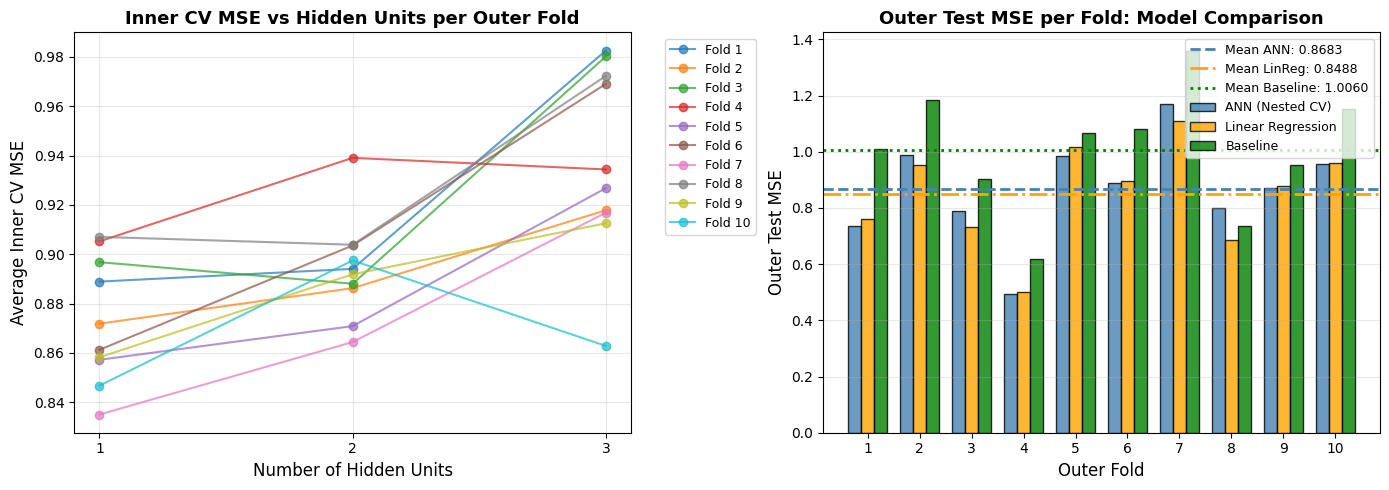

In [78]:
def plot_nested_cv_results(results_df, inner_errors_df):

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # --- Ensure results_df is a DataFrame ---
    if isinstance(results_df, dict):
        results_df = pd.DataFrame(results_df)
    
    # Ensure results_df is sorted by outer_fold for consistent plotting
    if 'outer_fold' in results_df.columns:
        results_df = results_df.sort_values('outer_fold')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- Plot 1: MSE vs Hidden Units for each outer fold ---
    ax1 = axes[0]
    for outer_fold in sorted(inner_errors_df['outer_fold'].unique()):
        fold_data = inner_errors_df[inner_errors_df['outer_fold'] == outer_fold]
        fold_data = fold_data.sort_values('hidden_units')
        ax1.plot(
            fold_data['hidden_units'], fold_data['avg_mse'],
            marker='o', label=f'Fold {outer_fold}', alpha=0.7,
        )
    
    ax1.set_xlabel('Number of Hidden Units', fontsize=12)
    ax1.set_ylabel('Average Inner CV MSE', fontsize=12)
    ax1.set_title('Inner CV MSE vs Hidden Units per Outer Fold', fontsize=13, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(sorted(inner_errors_df['hidden_units'].unique()))
    
    # --- Plot 2: Outer Test MSE per Fold (Comparison of all three models) ---
    ax2 = axes[1]
    folds = results_df['outer_fold'].values
    
    # Plot all three models
    width = 0.25
    x = np.arange(len(folds))
    
    ax2.bar(x - width, results_df['ann_test_error'].values,
            width, label='ANN (Nested CV)', color='steelblue', alpha=0.8, edgecolor='black')
    ax2.bar(x, results_df['linreg_test_error'].values,
            width, label='Linear Regression', color='orange', alpha=0.8, edgecolor='black')
    ax2.bar(x + width, results_df['baseline_test_error'].values,
            width, label='Baseline', color='green', alpha=0.8, edgecolor='black')
    
    # Mean lines
    mean_ann = results_df['ann_test_error'].mean()
    mean_linreg = results_df['linreg_test_error'].mean()
    mean_baseline = results_df['baseline_test_error'].mean()
    
    ax2.axhline(y=mean_ann, color='steelblue', linestyle='--', linewidth=2,
                label=f'Mean ANN: {mean_ann:.4f}')
    ax2.axhline(y=mean_linreg, color='orange', linestyle='-.', linewidth=2,
                label=f'Mean LinReg: {mean_linreg:.4f}')
    ax2.axhline(y=mean_baseline, color='green', linestyle=':', linewidth=2,
                label=f'Mean Baseline: {mean_baseline:.4f}')
    
    ax2.set_xlabel('Outer Fold', fontsize=12)
    ax2.set_ylabel('Outer Test MSE', fontsize=12)
    ax2.set_title('Outer Test MSE per Fold: Model Comparison', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(x)
    ax2.set_xticklabels(folds)
    
    plt.tight_layout()
    plt.show()
    
    return fig
fig1 = plot_nested_cv_results(results_df, inner_errors_df)


In [86]:
# TODO: results of the ANN may change between runs due to random initialization of the weights so check results after last run. 
# We may get a case with ANN outperforming Linear Regression

We can observe that one hidden unit shows the best MSE accross every outer fold.

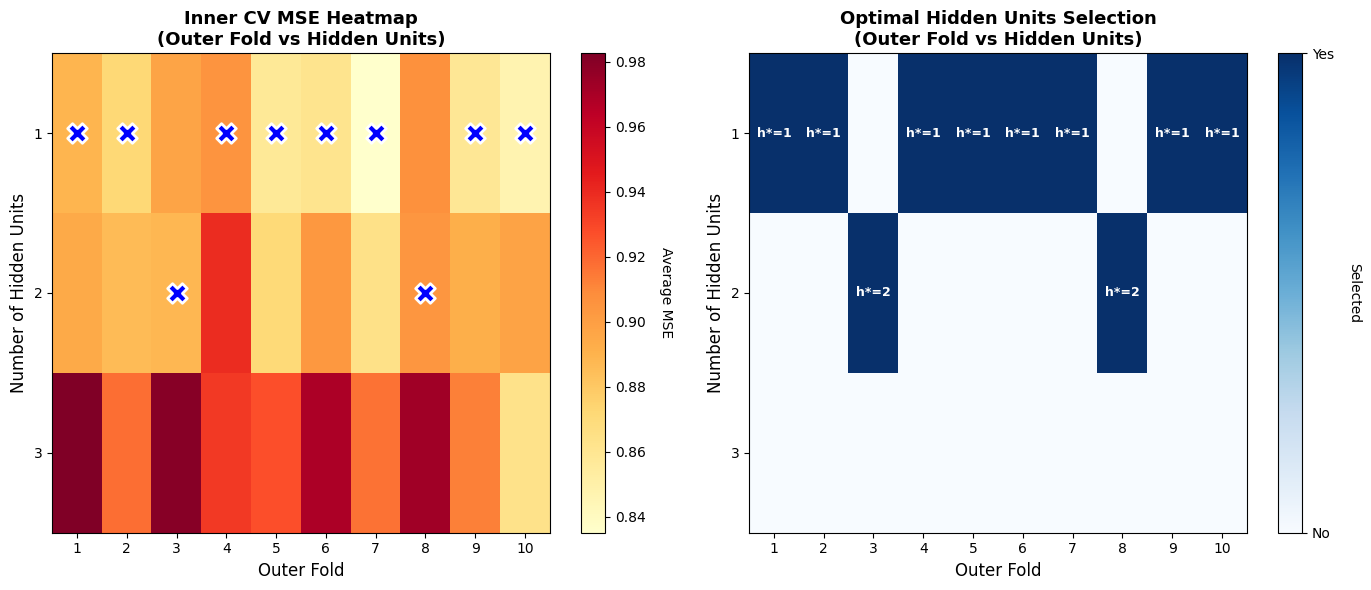

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_hidden_units_heatmaps(results_df, inner_errors_df):
    
    # Ensure DataFrames
    if isinstance(results_df, dict):
        results_df = pd.DataFrame(results_df)
    if isinstance(inner_errors_df, dict):
        inner_errors_df = pd.DataFrame(inner_errors_df)
    
    # Get unique values
    outer_folds = sorted(inner_errors_df['outer_fold'].unique())
    hidden_units_range = sorted(inner_errors_df['hidden_units'].unique())
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Plot 1: Heatmap of MSE (Outer Fold vs Hidden Units) ---
    # Create pivot table: rows = hidden units, columns = outer folds
    pivot_mse = inner_errors_df.pivot_table(
        values='avg_mse', 
        index='hidden_units', 
        columns='outer_fold'
    )
    pivot_mse = pivot_mse.reindex(index=hidden_units_range, columns=outer_folds)
    
    im1 = axes[0].imshow(pivot_mse.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    axes[0].set_yticks(range(len(hidden_units_range)))
    axes[0].set_yticklabels(hidden_units_range)
    axes[0].set_xticks(range(len(outer_folds)))
    axes[0].set_xticklabels(outer_folds)
    axes[0].set_xlabel('Outer Fold', fontsize=12)
    axes[0].set_ylabel('Number of Hidden Units', fontsize=12)
    axes[0].set_title('Inner CV MSE Heatmap\n(Outer Fold vs Hidden Units)', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=axes[0])
    cbar1.set_label('Average MSE', rotation=270, labelpad=20)
    
    # Mark optimal hidden units with X
    for i, outer_fold in enumerate(outer_folds):
        optimal_h = results_df[results_df['outer_fold'] == outer_fold]['h_star'].values[0]
        h_idx = hidden_units_range.index(optimal_h)
        axes[0].scatter(i, h_idx, marker='X', s=200, c='blue', edgecolors='white', linewidths=2, zorder=10)
    
    # --- Plot 2: Heatmap of Optimal Selection (Outer Fold vs Hidden Units) ---
    # Binary grid: 1 if hidden unit was selected as optimal, 0 otherwise
    selection_grid = np.zeros((len(hidden_units_range), len(outer_folds)))
    
    for i, outer_fold in enumerate(outer_folds):
        optimal_h = results_df[results_df['outer_fold'] == outer_fold]['h_star'].values[0]
        h_idx = hidden_units_range.index(optimal_h)
        selection_grid[h_idx, i] = 1
    
    im2 = axes[1].imshow(selection_grid, aspect='auto', cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
    axes[1].set_yticks(range(len(hidden_units_range)))
    axes[1].set_yticklabels(hidden_units_range)
    axes[1].set_xticks(range(len(outer_folds)))
    axes[1].set_xticklabels(outer_folds)
    axes[1].set_xlabel('Outer Fold', fontsize=12)
    axes[1].set_ylabel('Number of Hidden Units', fontsize=12)
    axes[1].set_title('Optimal Hidden Units Selection\n(Outer Fold vs Hidden Units)', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=axes[1], ticks=[0, 1])
    cbar2.set_label('Selected', rotation=270, labelpad=20)
    cbar2.set_ticklabels(['No', 'Yes'])
    
    # Add text annotations showing which h* was selected
    for i, outer_fold in enumerate(outer_folds):
        optimal_h = results_df[results_df['outer_fold'] == outer_fold]['h_star'].values[0]
        h_idx = hidden_units_range.index(optimal_h)
        axes[1].text(i, h_idx, f'h*={optimal_h}', ha='center', va='center', 
                    fontsize=9, fontweight='bold', color='white')
    
    plt.tight_layout()
    plt.show()
    
    return fig

fig2 = plot_hidden_units_heatmaps(results_df, inner_errors_df)

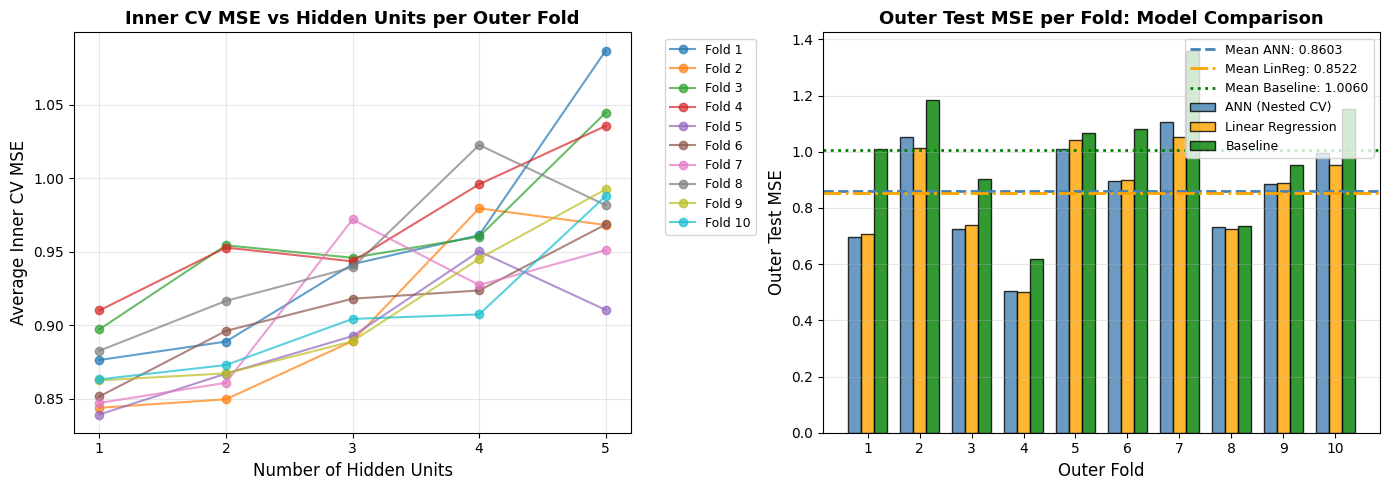

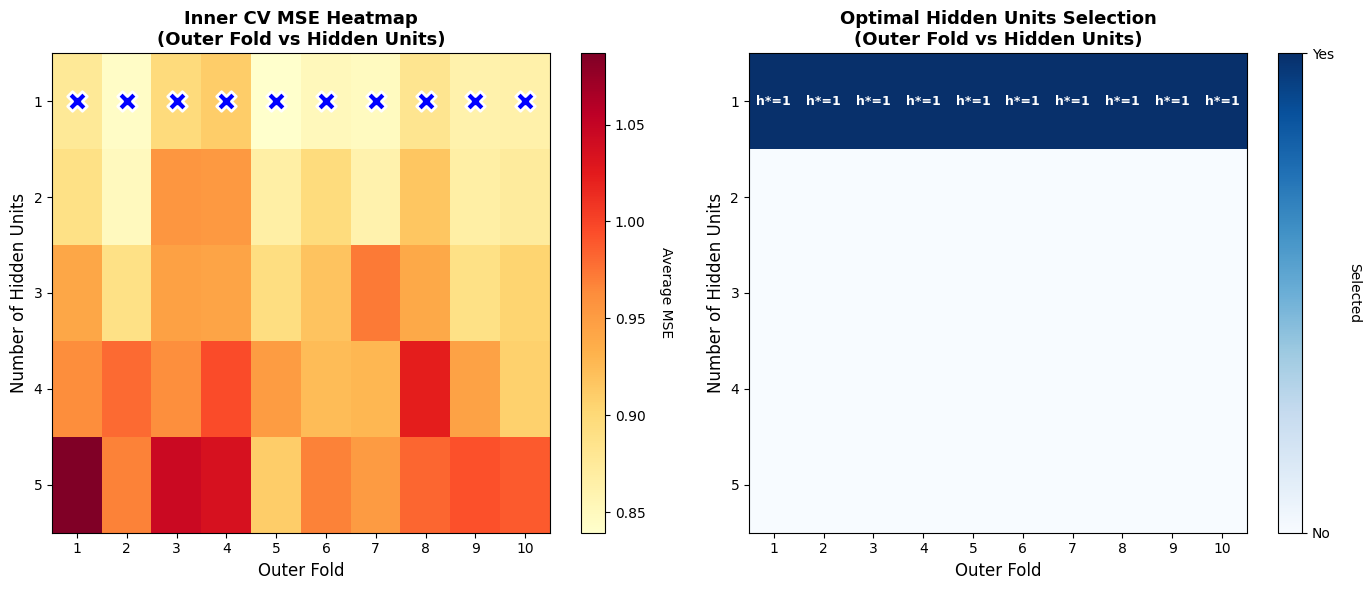

In [87]:
# figs for PCA data
fig1_pca = plot_nested_cv_results(results_df_pca, inner_errors_df_pca)
fig2_pca = plot_hidden_units_heatmaps(results_df_pca, inner_errors_df_pca)

The color of the heatmap represents the average MSE, where lighter colors indicate lower values. The map shows the performance of each configuration across the inner folds within each outer fold. By observing the lighter regions, we can identify which number of hidden units achieved a lower MSE in the inner folds for each outer fold. The heatmap on the right summarizes the one on the left, presenting the final results without color intensities, focusing instead on the relationship between the hidden units and the inner folds.

---

## 2. Table of Results

Produce a table akin to **Table 1** using two-level cross-validation (*Algorithm 6 in the lecture notes*).

The table should show, for each of the **K₁ = 10 folds (i)**:
- The optimal number of hidden units (**h\*_ᵢ**)  
- The optimal regularization strength (**λ\*_ᵢ**) as found after each inner loop  
- The estimated generalization error (**Etest_ᵢ**) by evaluating on **Dtest_ᵢ**  
- The **baseline test error**, also evaluated on **Dtest_ᵢ**

> **Important:** You must re-use the **train/test splits (Dpar_ᵢ, Dtest_ᵢ)** for all three methods to allow **statistical comparison** (see next section).


In [91]:
summary_table

,Outer fold,ANN,E^test,LinReg E^test,optimal lambda value,Baseline E^test
0,1,1,0.736979,0.760806,N/A,1.011163
1,2,1,0.989838,0.954374,N/A,1.184250
2,3,2,0.788435,0.731227,N/A,0.904084
3,4,1,0.495336,0.501742,N/A,0.619261
4,5,1,0.985328,1.015120,N/A,1.065526
5,6,1,0.887522,0.894966,N/A,1.079730
6,7,1,1.170035,1.109058,N/A,1.356940
7,8,2,0.800672,0.684068,N/A,0.736631
8,9,1,0.872528,0.877607,N/A,0.951900
9,10,1,0.956513,0.959180,N/A,1.150944


In [92]:
summary_table_pca

,Outer fold,ANN,E^test,LinReg E^test,optimal lambda value,Baseline E^test
0,1,1,0.694965,0.707682,N/A,1.011163
1,2,1,1.050858,1.014259,N/A,1.184250
2,3,1,0.723446,0.738354,N/A,0.904084
3,4,1,0.504518,0.500234,N/A,0.619261
4,5,1,1.009292,1.041082,N/A,1.065526
5,6,1,0.897042,0.899153,N/A,1.079730
6,7,1,1.106731,1.053033,N/A,1.356940
7,8,1,0.733262,0.726678,N/A,0.736631
8,9,1,0.886471,0.888060,N/A,0.951900
9,10,1,0.996192,0.953103,N/A,1.150944


---

## 3. Statistical Evaluation

Statistically evaluate whether there is a **significant performance difference** between the fitted ANN, linear regression model, and baseline using the methods described in **Chapter 11**.

These comparisons will be made **pairwise**:
- ANN vs. Linear Regression  
- ANN vs. Baseline  
- Linear Regression vs. Baseline  

You may choose between two setups:

### **Setup I (Section 11.3)**  
Use the **paired t-test** described in *Section 11.3.4*.

### **Setup II (Section 11.4)**  
Use the method described in *Section 11.4.1*.



Once we have the optimal parameters for both the Linear Regressor and the ANN we can perform the statistical analysis of the data.

In [ ]:
# TODO: optimal regularization parameter missing in Linear Regression

In [104]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as st
from sklearn.dummy import DummyRegressor

seed = 42
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

y_true = []
y_preds = {"Model_A": [], "Model_B": [], "Model_C": []}

mse_A = []
mse_B = []
mse_C = []


for fold, (train_index, test_index) in tqdm(
    enumerate(CV_kfold.split(X)), desc="Crossvalidation fold", total=CV_kfold.get_n_splits(X)
):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize per fold
    mean_train = X_train.mean(axis=0)
    std_train = X_train.std(axis=0)
    std_train[std_train == 0] = 1e-8
    X_train = (X_train - mean_train) / std_train
    X_test = (X_test - mean_train) / std_train

    # Train models
    model_A = LinearRegression() # optimal regularization parameter missing
    model_A.fit(X_train, y_train)

    model_B = get_model(input_dim=X.shape[1], hidden_dim=3, output_dim=1)
    model_B = train_pytorch_model(model_B, X_train, y_train, epochs=1000, lr=0.01)
    # baseline
    Model_C = DummyRegressor(strategy="mean")

    # Fit it on the training targets
    Model_C.fit(X_train, y_train)

    # Predict (it will always output the mean of y_train)
    y_pred_baseline = Model_C.predict(X_test)

    # Predict
    y_preds_A = model_A.predict(X_test)
    y_preds_B = predict_pytorch_model(model_B,X_test)
    y_preds_C = Model_C.predict(X_test)

    # Store
    y_preds["Model_A"].append(y_preds_A)
    y_preds["Model_B"].append(y_preds_B)
    y_preds["Model_C"].append(y_preds_C)
    y_true.append(y_test)

    mse_A.append(mean_squared_error(y_test, y_preds_A))
    mse_B.append(mean_squared_error(y_test, y_preds_B))
    mse_C.append(mean_squared_error(y_test, y_preds_C))

# Merge results
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

# Define loss
l2_loss = lambda y, y_pred: (y - y_pred)**2


# def confidence_interval(y_true, y_preds, loss_fn, alpha=0.05):
#     z = loss_fn(y_true, y_preds)
#     z_hat = np.mean(z)
#     n = len(z)
#     sem = np.std(z, ddof=1) / np.sqrt(n)
#     CI = st.t.interval(confidence=1 - alpha, df=n - 1, loc=z_hat, scale=sem)
#     return z_hat, CI
def confidence_interval(y_true, y_preds, loss_fn, alpha=0.05):
    # Calculate estimated error, z_hat, as the mean loss across all samples
    z = loss_fn(y_true, y_preds)
    z_hat = np.mean(z)
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # Calculate standard error of the mean of the losses (sem)
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))

    # Calculate the confidence interval
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval

    return z_hat, CI


# Compute CIs
for model_name, preds in y_preds.items():
    z_hat, CI = confidence_interval(y_true, preds, l2_loss, alpha=0.05)
    print(f"{model_name}: MSE={z_hat:.4f}, 95% CI=({CI[0]:.4f}, {CI[1]:.4f})")


Crossvalidation fold: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

Model_A: MSE=0.8489, 95% CI=(0.6977, 1.0000)
Model_B: MSE=0.8841, 95% CI=(0.7306, 1.0376)
Model_C: MSE=1.0064, 95% CI=(0.8283, 1.1846)


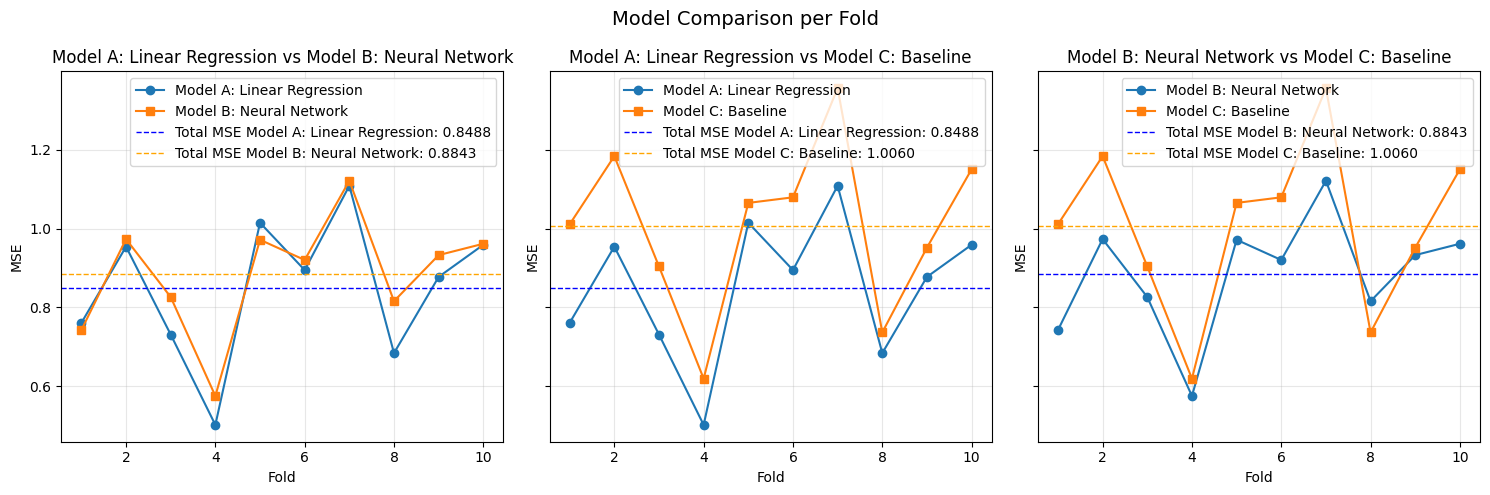

In [110]:

folds = np.arange(1, 11)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Model Comparison per Fold", fontsize=14)

# Define model names and data
model_pairs = [
    ("Model A: Linear Regression", mse_A, "Model B: Neural Network", mse_B),
    ("Model A: Linear Regression", mse_A, "Model C: Baseline", mse_C),
    ("Model B: Neural Network", mse_B, "Model C: Baseline", mse_C),
]

# Plot each pair
for ax, (name1, mse1, name2, mse2) in zip(axes, model_pairs):
    ax.plot(folds, mse1, marker="o", label=name1)
    ax.plot(folds, mse2, marker="s", label=name2)
    ax.set_xlabel("Fold")
    ax.set_ylabel("MSE")
    ax.set_title(f"{name1} vs {name2}")
    ax.legend()
    ax.grid(True, alpha=0.3)
# add mean lines
    mean1 = np.mean(mse1)
    mean2 = np.mean(mse2)
    ax.axhline(y=mean1, color='blue', linestyle='--', linewidth=1,
                label=f'Total MSE {name1}: {mean1:.4f}')
    ax.axhline(y=mean2, color='orange', linestyle='--', linewidth=1,
                label=f'Total MSE {name2}: {mean2:.4f}')
    ax.legend()

plt.tight_layout()
plt.show()


In [106]:
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # 4.1) Calculate estimated error, z_hat, as the mean loss across all samples
    ### BEGIN SOLUTION
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    ### END SOLUTION
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 4.2) Insert solution from task 3.6 here
    ### BEGIN SOLUTION
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    ### END SOLUTION
    
    # 4.3) Insert solution from task 3.7 here
    ### BEGIN SOLUTION
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    ### END SOLUTION

    # 4.4) Calculate the p-value for the two-sided test using the t-distribution
    ### BEGIN SOLUTION
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value
    ### END SOLUTION

    return z_hat, CI, p_value

# Compare Model_A and Model_B
z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_B"], l2_loss, alpha=0.05)
print(f"Difference in loss between Model_A and Model_B: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")
# compare Model_A and Model_C
z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_C"], l2_loss, alpha=0.05)
print(f"Difference in loss between Model_A and Model_C: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")
# compare Model_B and Model_C
z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds["Model_B"], y_preds["Model_C"], l2_loss, alpha=0.05)
print(f"Difference in loss between Model_B and Model_C: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")
                                                                

Difference in loss between Model_A and Model_B: 
z_hat: -0.0353, 
CI: [-0.0733, 0.0027], 
p-value: 0.06861356168352944
Difference in loss between Model_A and Model_C: 
z_hat: -0.1576, 
CI: [-0.2244, -0.0907], 
p-value: 4.705852048487805e-06
Difference in loss between Model_B and Model_C: 
z_hat: -0.1223, 
CI: [-0.2057, -0.0389], 
p-value: 0.004142880858264645


The confidence interval measures the range of possible values for the true mean difference. Meanwhile the p-value measures the probability that such a difference arises by chance.
Linear Regression outperforms both, the Artificial neural network and the baseline model. However, between the linear Regression and the ANN we see the value 0 within the confidence interval and the p-value is lower than 0.05 which means an statistically insignificant difference. In other words, the difference could appear due to statistical error. This indicates no clear improvement between the Linear Regression and the ANN. 

---

## 4. Reporting

Include in your report:
- **p-values** and **confidence intervals** for the three pairwise tests  
- Your **conclusions** based on the results:
  - Is one model better than the other?  
  - Are both models better than the baseline?  
  - Are some models statistically identical?  
  - What **recommendations** would you make based on what you’ve learned?


Non-linear activation functions can add unnecessary complexity to the model, which may reduce accuracy when the underlying data exhibits a mostly linear behavior.
In some cases, the generalization error may also worsen when using PCA, since this technique reduces both the total variance and the dimensionality of the dataset. In a medical application like this one, aimed at predicting systolic blood pressure, the priority is to achieve the highest possible accuracy and confidence. Therefore, based on this analysis, it is reasonable to conclude that using all the available data is the best choice.